In [3]:
!pip install kneed
import pandas as pd
import sklearn
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from kneed import KneeLocator
import scipy.stats as stats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
NTS_dummy = pd.read_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/NTS_v2.csv')
NTS_dummy.shape

(2445, 174)

In [5]:
# replace NA with zero
#na occurs for std of users with one trip, or count of users with no weekend trip
NTS_dummy = NTS_dummy.fillna(0)

In [6]:
mobility = NTS_dummy.iloc[:,51:]
socio = NTS_dummy.drop(columns = ['IndividualID','SurveyYear']).iloc[:,0:49]

In [7]:
socio_cols = {'age' : socio.columns[0:6],
'sex' : socio.columns[6:8],
'marital' : socio.columns[8:10],
'income': socio.columns[10:13],
'work': socio.columns[13:16],
'hhincome': socio.columns[16:19],
'hh_struc': socio.columns[19:25],
'hh_work': socio.columns[25:28],
'hh_socialclass': socio.columns[28:34],
'urban_rural': socio.columns[34:36],
'region':socio.columns[36:49]}

## K-means Clustering

In [54]:
#normalize
x = mobility
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
#pca
#keep 85% of variance explained by selected components
pca = PCA(n_components=0.80)
principalComponents = pca.fit_transform(x)
pca.n_components_
#12 components are selected

9

In [83]:
pd.DataFrame(principalComponents)

,0,1,2,3,4,5,6,7,8
0,0.433323,-0.448948,-0.749918,-0.709838,-0.086891,-0.640586,-0.126142,-0.241830,-0.339744
1,-0.703868,0.245957,-1.494279,0.988143,0.941267,0.278714,-0.751627,1.009392,-0.192041
2,0.118961,-1.064025,0.655979,0.003376,-0.420408,0.556576,0.010147,-0.270633,-0.016619
3,0.699355,-1.271432,0.783697,1.429020,0.885066,-0.279343,0.292363,-0.433254,0.433595
4,0.539601,-1.474594,0.689921,0.662095,1.237305,0.605200,0.388145,-0.805201,0.373102
...,...,...,...,...,...,...,...,...,...
2440,-1.029328,-0.317266,-0.330438,0.506568,0.487155,-0.235773,-0.501195,0.470267,0.087867
2441,-0.904174,0.055883,-0.426293,1.222464,-0.147205,0.304509,-0.733886,0.555383,-0.360998
2442,-0.167760,0.155549,0.941593,0.753111,1.303717,-0.046995,-0.811736,0.214991,-0.362477
2443,0.788752,0.511427,0.298805,1.106295,1.068143,0.110079,-1.081623,0.527354,-0.585350


In [84]:
#component big contributers
#TOP 10 vars 
#PC1
pd.DataFrame(pca.components_,columns=mobility.columns).iloc[0,:]\
.sort_values(ascending=False,key=abs)[0:10]
# PC1: NOT having shorter travel times and distances, percentage and std

%_travel_short_wk     -0.255928
%_time_short_wk       -0.249681
%_travel_short        -0.232220
%_time_short          -0.226694
std_time_short_wk     -0.225946
std_travel_short_wk   -0.217906
%_end_offpeak_wk      -0.204147
%_travel_mid_wk        0.202410
%_start_offpeak_wk    -0.198838
std_time_short        -0.194920
Name: 0, dtype: float64

In [86]:
#PC2
pd.DataFrame(pca.components_,columns=mobility.columns).iloc[1,:]\
.sort_values(ascending=False,key =abs)[:10]
#NOT doing trips regularly during the morning peak (low std: either no trips or daily trips)
#high percentage of offpeak trips

std_end_morningpeak_wk     -0.228051
std_start_morningpeak_wk   -0.209846
%_end_offpeak_wk            0.201388
%_start_offpeak_wk          0.200031
std_end_morningpeak        -0.199445
std_start_eveningpeak_wk   -0.190909
%_end_offpeak               0.190377
%_start_offpeak             0.190114
std_start_morningpeak      -0.179956
std_end_eveningpeak_wk     -0.164677
Name: 1, dtype: float64

In [87]:
#PC3
pd.DataFrame(pca.components_,columns=mobility.columns).iloc[2,:]\
.sort_values(ascending=False,key=abs)[:10]
#ocassional long trip distance and travel 


std_time_long               0.274842
std_time_long_wk            0.271837
std_travel_long             0.266657
std_travel_long_wk          0.261571
std_end_night_wk            0.181912
std_end_night               0.170730
std_end_morningpeak_wk     -0.157150
std_end_morningpeak        -0.152129
%_time_long_wk              0.151031
std_start_morningpeak_wk   -0.149868
Name: 2, dtype: float64

In [88]:
#PC4
pd.DataFrame(pca.components_,columns=mobility.columns).iloc[3,:]\
.sort_values(ascending=False,key=abs)[:10]
#Not having mid-range trips, 

%_time_mid_wk              -0.286693
%_travel_mid_wk            -0.280170
%_time_mid                 -0.234851
%_travel_mid               -0.229922
std_end_offpeak_wk         -0.192447
std_start_offpeak_wk       -0.190252
std_travel_mid_wk          -0.181709
std_start_morningpeak_wk   -0.178880
%_time_short_wk             0.175349
std_time_mid_wk            -0.174590
Name: 3, dtype: float64

In [61]:
#PC5
pd.DataFrame(pca.components_,columns=mobility.columns).iloc[4,:].abs()\
.sort_values(ascending=False)[:10]
#ocassional long night trips 

std_start_night_wk    0.240159
std_start_night       0.226148
std_time_long         0.221821
std_travel_long       0.219701
%_time_mid_wk         0.209111
std_end_night_wk      0.203022
std_time_long_wk      0.202647
std_travel_long_wk    0.201726
%_time_long_wk        0.196240
std_end_night         0.193962
Name: 4, dtype: float64

In [62]:
#PC6
pd.DataFrame(pca.components_,columns=mobility.columns).iloc[5,:].abs()\
.sort_values(ascending=False)[:10]
#occasional evening and night peak trips, 

std_end_eveningpeak_wk      0.268081
std_end_night_wk            0.244712
std_end_night               0.236276
std_start_night_wk          0.231143
std_end_eveningpeak         0.230149
std_start_eveningpeak_wk    0.229581
std_start_night             0.225512
std_start_eveningpeak       0.199384
%_end_eveningpeak_wk        0.192261
%_end_eveningpeak           0.161743
Name: 5, dtype: float64

In [63]:
#PC7
pd.DataFrame(pca.components_,columns=mobility.columns).iloc[6,:].abs()\
.sort_values(ascending=False)[:10]
#occasional early in the morning travelers 

std_start_earlymorning_wk      0.323354
std_start_earlymorning         0.312439
std_end_earlymorning_wk        0.236875
std_end_earlymorning           0.234977
std_end_eveningpeak_wk         0.217096
std_start_eveningpeak_wk       0.197797
std_end_offpeak_wk             0.190907
std_end_eveningpeak            0.186999
Count_start_earlymorning_wk    0.177423
Count_start_earlymorning       0.175193
Name: 6, dtype: float64

In [64]:
#PC8
pd.DataFrame(pca.components_,columns=mobility.columns).iloc[7,:].abs()\
.sort_values(ascending=False)[:10]
#occasional offpeak and early morning travelers

std_start_offpeak_wk         0.362342
std_end_offpeak_wk           0.351864
std_start_earlymorning_wk    0.244127
std_start_earlymorning       0.228613
std_start_offpeak            0.196821
std_end_earlymorning_wk      0.189764
std_end_offpeak              0.189637
std_travel_mid               0.180916
std_end_earlymorning         0.179225
std_time_mid                 0.171659
Name: 7, dtype: float64

In [65]:
#PC9
pd.DataFrame(pca.components_,columns=mobility.columns).iloc[8,:].abs()\
.sort_values(ascending=False)[:10]
#occasional offpeak travelers + high number of trips

std_end_offpeak_wk            0.278305
std_start_offpeak_wk          0.270132
std_end_offpeak               0.252600
std_start_offpeak             0.248318
Count_Weekday_Trips           0.219420
Total Number of Trips         0.213733
Count_start_eveningpeak_wk    0.188308
Count_end_eveningpeak         0.186049
Count_end_eveningpeak_wk      0.183731
Count_start_offpeak           0.182076
Name: 8, dtype: float64

For n_clusters = 2 The average silhouette_score is : 0.1878106005544528
For n_clusters = 3 The average silhouette_score is : 0.1440826099279285
For n_clusters = 4 The average silhouette_score is : 0.15936090738638917
For n_clusters = 5 The average silhouette_score is : 0.15945247854070488
For n_clusters = 6 The average silhouette_score is : 0.1597185634596219
For n_clusters = 7 The average silhouette_score is : 0.15081268478941828
For n_clusters = 8 The average silhouette_score is : 0.1483809020508164
For n_clusters = 9 The average silhouette_score is : 0.15443975595137244
For n_clusters = 10 The average silhouette_score is : 0.1542645308998341
For n_clusters = 11 The average silhouette_score is : 0.15409602550009585
For n_clusters = 12 The average silhouette_score is : 0.1546961774166107
For n_clusters = 13 The average silhouette_score is : 0.15048875122265398
For n_clusters = 14 The average silhouette_score is : 0.15171737844956412
For n_clusters = 15 The average silhouette_score is 

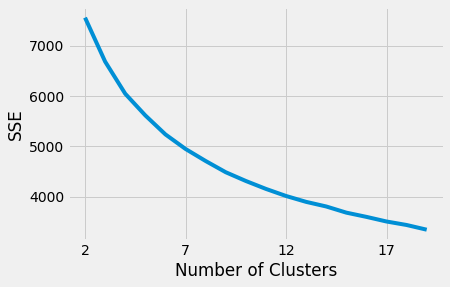

Number of clusters is: 7


In [67]:
# number of clusters
 
def elbow(pcs):

  kmeans_kwargs = {
      "init": "random",
      "n_init": 10,
      "max_iter": 300,
      "random_state": 42,
  }

  # A list holds the SSE values for each k
  sse = []
  #fig, ax = plt.subplots(10, 2, figsize=(15,16))

  max_cluster = min(20,pcs.shape[0])
  for k in range(2, max_cluster):
      kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
      kmeans.fit(pcs)
      cluster_labels = kmeans.fit_predict(pcs)
      silhouette_avg = silhouette_score(pcs, cluster_labels)
      print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
      sse.append(kmeans.inertia_)
      # q, mod = divmod(k, 2)
      # '''
      # Create SilhouetteVisualizer instance with KMeans instance
      # Fit the visualizer
      # '''
      # visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
      # visualizer.fit(features)

  plt.style.use("fivethirtyeight")
  plt.plot(range(2, max_cluster), sse)
  plt.xticks(range(2, max_cluster,5))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  plt.show()

  kl = KneeLocator(
    range(2, max_cluster), sse, curve="convex", direction="decreasing"
  )
  print('Number of clusters is:',  kl.elbow)
  return 

elbow(principalComponents)

In [72]:
#kmeans function
def kplot(pcs,k):

  kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
  }

  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(pcs)
  cluster_labels = kmeans.fit_predict(pcs)
  df = pd.DataFrame(pcs)
  df['label'] = kmeans.labels_
  
  return df,kmeans.cluster_centers_

In [73]:
pc_df,centers = kplot(principalComponents,7)

In [78]:
pd.DataFrame(centers)


,0,1,2,3,4,5,6,7,8
0,0.516403,-0.218523,0.903160,0.026749,0.769171,0.007133,-0.033005,0.052410,-0.022667
1,-0.116205,-0.926587,-0.289647,-0.123099,-0.123112,-0.109946,0.080829,-0.068739,0.081823
2,1.490771,-0.066409,-0.526263,-0.108091,-0.114422,0.076900,-0.087767,-0.033059,0.008646
3,-0.822181,0.192913,-0.682750,1.062520,0.295471,0.193082,-0.254733,0.332856,-0.036984
4,0.728130,1.524652,-0.076431,0.037864,-0.198465,0.091179,0.014556,0.113691,0.045595
5,-0.950834,0.529812,-0.114437,-0.391633,0.137458,-0.177128,0.138729,-0.191242,-0.006227
6,-0.461601,-0.067410,0.500109,0.018418,-0.657809,0.109531,-0.027862,0.012686,-0.102663


#CLUSTER PROFILES
CLUSTER 0: 

In [70]:
pc_df.groupby('label').size()

label
0    366
1    543
2    290
3    216
4    245
5    402
6    383
dtype: int64

In [71]:
pc_df

,0,1,2,3,4,5,6,7,8,label
0,0.433323,-0.448948,-0.749918,-0.709838,-0.086891,-0.640586,-0.126142,-0.241830,-0.339744,1
1,-0.703868,0.245957,-1.494279,0.988143,0.941267,0.278714,-0.751627,1.009392,-0.192041,3
2,0.118961,-1.064025,0.655979,0.003376,-0.420408,0.556576,0.010147,-0.270633,-0.016619,1
3,0.699355,-1.271432,0.783697,1.429020,0.885066,-0.279343,0.292363,-0.433254,0.433595,0
4,0.539601,-1.474594,0.689921,0.662095,1.237305,0.605200,0.388145,-0.805201,0.373102,0
...,...,...,...,...,...,...,...,...,...,...
2440,-1.029328,-0.317266,-0.330438,0.506568,0.487155,-0.235773,-0.501195,0.470267,0.087867,3
2441,-0.904174,0.055883,-0.426293,1.222464,-0.147205,0.304509,-0.733886,0.555383,-0.360998,3
2442,-0.167760,0.155549,0.941593,0.753111,1.303717,-0.046995,-0.811736,0.214991,-0.362477,0
2443,0.788752,0.511427,0.298805,1.106295,1.068143,0.110079,-1.081623,0.527354,-0.585350,0


In [32]:
socio['label'] = pc_df['label']

## Statistical Test for clusters


In [33]:
def chi2stat(df,var):
  df = df.groupby('label').sum()[var]
  #for chi2 test, min freq should be at least 5
  var2 = (df>4).all()[(df>4).all()==True].index 
  
  chi2 = stats.chi2_contingency(df[var2])
  if len(var2)<2:
    print('Not enough data')
  print('P_value: ',chi2[1])
  return


In [34]:
vars = socio_cols.keys()

for v in vars:
  print(v)
  chi2stat(socio,socio_cols[v])
  print('-----')
  

age
P_value:  7.305968765295918e-68
-----
sex
P_value:  1.280448958884307e-11
-----
marital
P_value:  2.5239564778155158e-05
-----
income
P_value:  6.338109325342751e-38
-----
work
P_value:  5.690094862607322e-121
-----
hhincome
P_value:  2.8875854286259003e-32
-----
hh_struc
P_value:  1.0641789622009953e-27
-----
hh_work
P_value:  1.7353118037814107e-68
-----
hh_socialclass
P_value:  3.3465896031434087e-69
-----
urban_rural
P_value:  0.005074731917657885
-----
region
P_value:  7.487249962759098e-09
-----


All sociodemographic variables are significantly different among clusters

# COMPARE Sociodemographics among clusters

In [35]:
#AGE
# convert dummy to mean of band
tmp_df = pd.DataFrame()
tmp_df['age_band'] = socio[socio_cols['age']].idxmax(axis=1)

age_dict = {'Age_B04ID_4':	18.5, 
'Age_B04ID_5':	25,
'Age_B04ID_6':	35,
'Age_B04ID_7':	45,
'Age_B04ID_8':	55,
'Age_B04ID_9':	65}
for n in age_dict.keys():
  socio.loc[tmp_df["age_band"] == n, "AGE"] = age_dict[n]



In [36]:
socio[['AGE','label']].groupby('label').mean()

,AGE
label,
0,55.802998
1,51.325806
2,53.183750
3,44.877966
4,43.768245
5,48.405759
6,53.887029


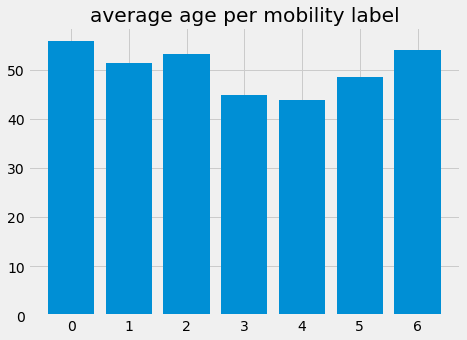

In [37]:
a = socio[['AGE','label']].groupby('label').mean()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = a.index
var = a.AGE
ax.bar(labels,var)
ax.set_title('average age per mobility label')
plt.show()

In [38]:
socio[['AGE','label']].groupby('label').median()

,AGE
label,
0,65.0
1,55.0
2,55.0
3,45.0
4,45.0
5,55.0
6,65.0


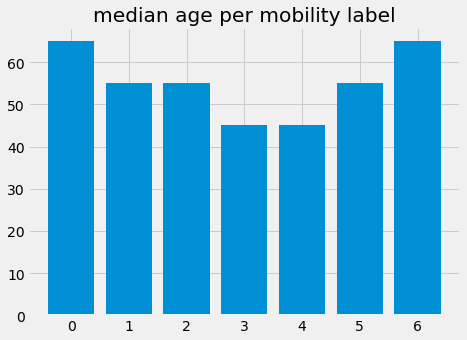

In [39]:
a = socio[['AGE','label']].groupby('label').median()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = a.index
var = a.AGE
ax.bar(labels,var)
ax.set_title('median age per mobility label')
plt.show()

In [40]:
#income
# convert dummy to mean of band
tmp_df = pd.DataFrame()
tmp_df['income_band'] = socio[socio_cols['income']].idxmax(axis=1)

income_dict = {'IndIncome2002_B02ID_1':	12.5, 
'IndIncome2002_B02ID_2':	37.5,
'IndIncome2002_B02ID_3':	62.5}
for n in income_dict.keys():
  socio.loc[tmp_df["income_band"] == n, "INCOME"] = income_dict[n]

socio[['INCOME','label']].groupby('label').mean()


,INCOME
label,
0,21.600642
1,24.274194
2,21.812500
3,29.533898
4,29.758383
5,34.293194
6,21.495816


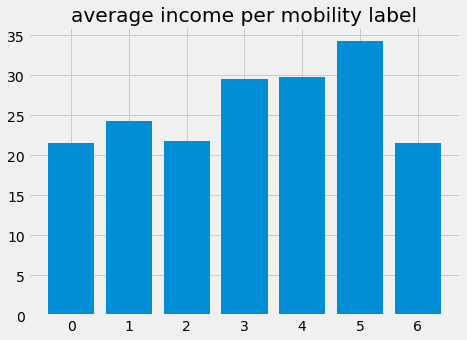

In [41]:
a = socio[['INCOME','label']].groupby('label').mean()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = a.index
var = a.INCOME
ax.bar(labels,var)
ax.set_title('average income per mobility label')
plt.show()

In [42]:
socio[['INCOME','label']].groupby('label').median()


,INCOME
label,
0,12.5
1,12.5
2,12.5
3,37.5
4,37.5
5,37.5
6,12.5


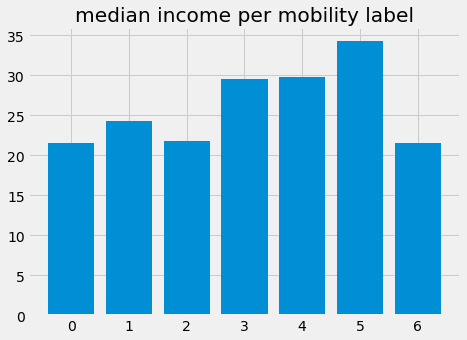

In [43]:
a = socio[['INCOME','label']].groupby('label').mean()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = a.index
var = a.INCOME
ax.bar(labels,var)
ax.set_title('median income per mobility label')
plt.show()

In [44]:
def mrg(var):
  lst = list(socio_cols[var])
  lst.append('label')
  return socio[lst].groupby('label').sum()

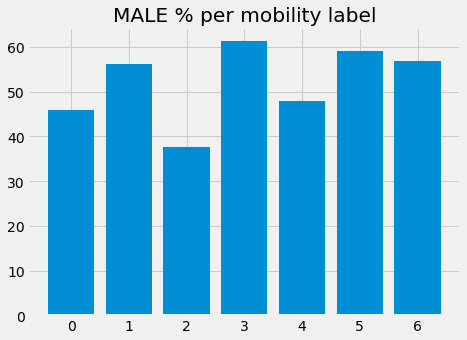

In [45]:
#GENDER
pops = mrg('sex').sum(axis=1)
perc = mrg('sex')['Sex_B01ID_1']/pops*100
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = perc.index
var = perc
ax.bar(labels,var)
ax.set_title('MALE % per mobility label')
plt.show()

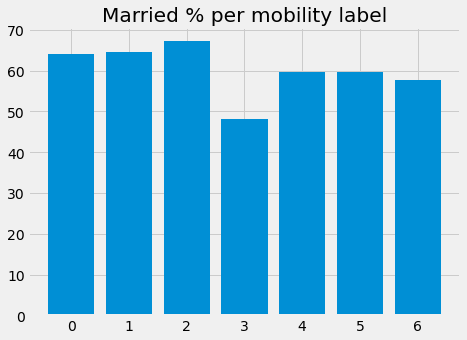

In [46]:
#marital
pops = mrg('marital').sum(axis=1)
perc = mrg('marital')['married']/pops*100
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = perc.index
var = perc
ax.bar(labels,var)
ax.set_title('Married % per mobility label')
plt.show()

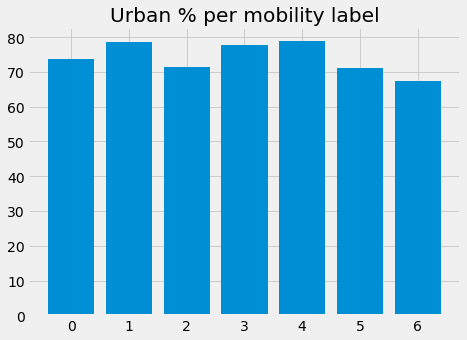

In [47]:
#urban rural
pops = mrg('urban_rural').sum(axis=1)
perc = mrg('urban_rural')['Settlement2011EW_B03ID_1']/pops*100
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = perc.index
var = perc
ax.bar(labels,var)
ax.set_title('Urban % per mobility label')
plt.show()

In [56]:
mrg('region')['PSUStatsReg_B01ID_1']/pops*100

label
0    1.927195
1    1.290323
2    1.000000
3    4.067797
4    0.788955
5    0.523560
6    1.255230
dtype: float64

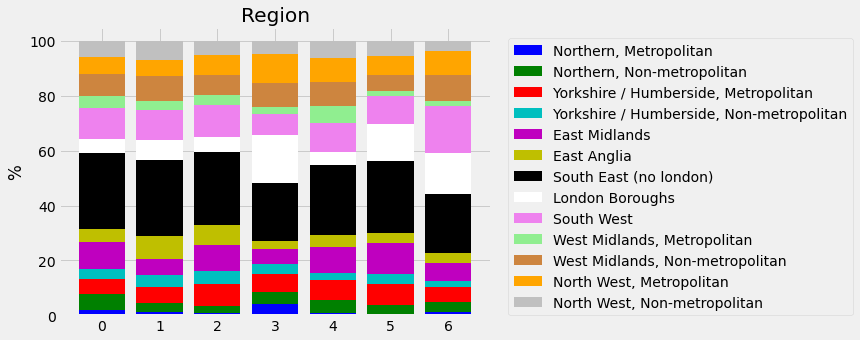

In [62]:
#region
pops = mrg('region').sum(axis=1)
r1 = mrg('region')['PSUStatsReg_B01ID_1']/pops*100
r2 = mrg('region')['PSUStatsReg_B01ID_2']/pops*100
r3 = mrg('region')['PSUStatsReg_B01ID_3']/pops*100
r4 = mrg('region')['PSUStatsReg_B01ID_4']/pops*100
r5 = mrg('region')['PSUStatsReg_B01ID_5']/pops*100
r6 = mrg('region')['PSUStatsReg_B01ID_6']/pops*100
r7 = mrg('region')['PSUStatsReg_B01ID_7']/pops*100
r8 = mrg('region')['PSUStatsReg_B01ID_8']/pops*100
r9 = mrg('region')['PSUStatsReg_B01ID_9']/pops*100
r10 = mrg('region')['PSUStatsReg_B01ID_10']/pops*100
r11 = mrg('region')['PSUStatsReg_B01ID_11']/pops*100
r12 = mrg('region')['PSUStatsReg_B01ID_12']/pops*100
r13 = mrg('region')['PSUStatsReg_B01ID_13']/pops*100


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = r1.index


ax.bar(labels, r1, color='b')
ax.bar(labels, r2,bottom=r1, color='g')
ax.bar(labels, r3,bottom=r1+r2, color='r')
ax.bar(labels, r4,bottom=r1+r2+r3, color='c')
ax.bar(labels, r5,bottom=r1+r2+r3+r4, color='m')
ax.bar(labels, r6,bottom=r1+r2+r3+r4+r5, color='y')
ax.bar(labels, r7,bottom=r1+r2+r3+r4+r5+r6, color='k')
ax.bar(labels, r8,bottom=r1+r2++r3+r4+r5+r6+r7, color='w')
ax.bar(labels, r9,bottom=r1+r2+r3+r4+r5+r6+r7+r8, color='violet')
ax.bar(labels, r10,bottom=r1+r2+r3+r4+r5+r6+r7+r8+r9, color='lightgreen')
ax.bar(labels, r11,bottom=r1+r2+r3+r4+r5+r6+r7+r8+r9+r10, color='peru')
ax.bar(labels, r12,bottom=r1+r2+r3+r4+r5+r6+r7+r8+r9+r10+r11, color='orange')
ax.bar(labels, r13,bottom=r1+r2+r3+r4+r5+r6+r7+r8+r9+r10+r11+r12, color='silver')


ax.set_ylabel('%')
ax.set_title('Region')
ax.legend(labels=['Northern, Metropolitan', 'Northern, Non-metropolitan',\
                  'Yorkshire / Humberside, Metropolitan','Yorkshire / Humberside, Non-metropolitan',\
                  'East Midlands','East Anglia','South East (no london)','London Boroughs',\
                  'South West','West Midlands, Metropolitan','West Midlands, Non-metropolitan',\
                  'North West, Metropolitan','North West, Non-metropolitan'],loc=(1.04, 0))
plt.show()




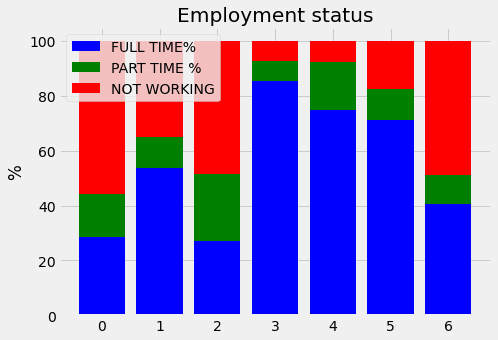

In [63]:
#work
pops = mrg('work').sum(axis=1)
full = mrg('work')['fulltime']/pops*100
part = mrg('work')['parttime']/pops*100
nowork = mrg('work')['not_working']/pops*100

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = full.index


ax.bar(labels, full, color='b')
ax.bar(labels, part,bottom=full, color='g')
ax.bar(labels, nowork,bottom=part+full, color='r')

ax.set_ylabel('%')
ax.set_title('Employment status')
ax.legend(labels=['FULL TIME%', 'PART TIME %', 'NOT WORKING'])
plt.show()

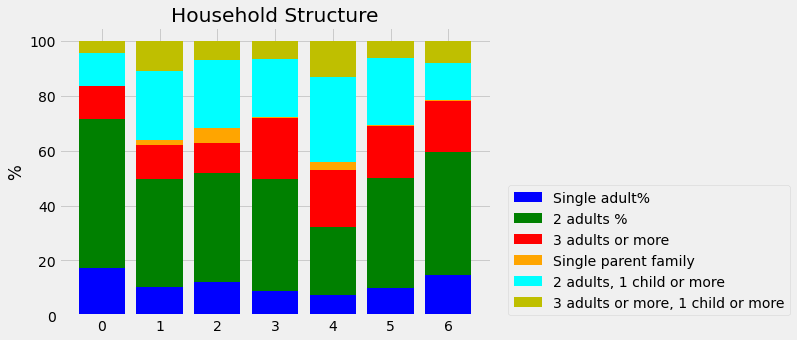

In [66]:
#household structure
pops = mrg('hh_struc').sum(axis=1)
single = mrg('hh_struc')['HHoldStruct_B02ID_1']/pops*100
two_adult = mrg('hh_struc')['HHoldStruct_B02ID_2']/pops*100
three_adult = mrg('hh_struc')['HHoldStruct_B02ID_3']/pops*100
single_parent_child = mrg('hh_struc')['HHoldStruct_B02ID_4']/pops*100
two_parents_child = mrg('hh_struc')['HHoldStruct_B02ID_5']/pops*100
three_adults_child = mrg('hh_struc')['HHoldStruct_B02ID_6']/pops*100

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = full.index


ax.bar(labels, single, color='b')
ax.bar(labels, two_adult,bottom=single, color='g')
ax.bar(labels, three_adult,bottom=two_adult+single, color='r')
ax.bar(labels, single_parent_child,bottom=two_adult+single+three_adult, color='orange')
ax.bar(labels, two_parents_child,bottom=two_adult+single+three_adult+\
       single_parent_child, color='cyan')
ax.bar(labels, three_adults_child,bottom=two_adult+single+\
       three_adult+single_parent_child+two_parents_child, color='y')

ax.set_ylabel('%')
ax.set_title('Household Structure')

ax.legend(labels=['Single adult%', '2 adults %', '3 adults or more',\
                  'Single parent family','2 adults, 1 child or more',\
                  '3 adults or more, 1 child or more'],loc=(1.04, 0))
plt.show()

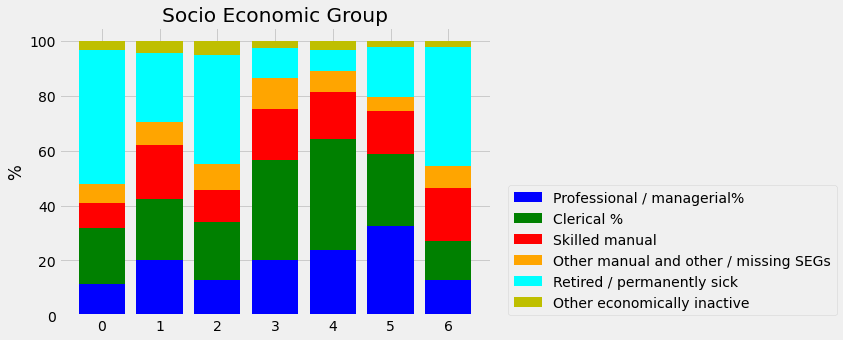

In [65]:
#social class 
pops = mrg('hh_socialclass').sum(axis=1)
single = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_1']/pops*100
two_adult = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_2']/pops*100
three_adult = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_3']/pops*100
single_parent_child = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_4']/pops*100
two_parents_child = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_5']/pops*100
three_adults_child = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_6']/pops*100

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = full.index


ax.bar(labels, single, color='b')
ax.bar(labels, two_adult,bottom=single, color='g')
ax.bar(labels, three_adult,bottom=two_adult+single, color='r')
ax.bar(labels, single_parent_child,bottom=two_adult+single+three_adult, color='orange')
ax.bar(labels, two_parents_child,bottom=two_adult+single+three_adult+\
       single_parent_child, color='cyan')
ax.bar(labels, three_adults_child,bottom=two_adult+single+\
       three_adult+single_parent_child+two_parents_child, color='y')

ax.set_ylabel('%')
ax.set_title('Socio Economic Group')

ax.legend(labels=['Professional / managerial%', 'Clerical %', 'Skilled manual',\
                  'Other manual and other / missing SEGs','Retired / permanently sick',\
                  'Other economically inactive'],loc=(1.04, 0))
plt.show()

In [ ]:
socio.columns

Index(['Age_B04ID_4', 'Age_B04ID_5', 'Age_B04ID_6', 'Age_B04ID_7',
       'Age_B04ID_8', 'Age_B04ID_9', 'Sex_B01ID_1', 'Sex_B01ID_2', 'married',
       'not_married', 'IndIncome2002_B02ID_1', 'IndIncome2002_B02ID_2',
       'IndIncome2002_B02ID_3', 'fulltime', 'parttime', 'not_working',
       'HHIncome2002_B02ID_1', 'HHIncome2002_B02ID_2', 'HHIncome2002_B02ID_3',
       'HHoldStruct_B02ID_1', 'HHoldStruct_B02ID_2', 'HHoldStruct_B02ID_3',
       'HHoldStruct_B02ID_4', 'HHoldStruct_B02ID_5', 'HHoldStruct_B02ID_6',
       'hh_fulltime', 'hh_parttime', 'hh_not_working',
       'HRPSEGWorkStat_B01ID_1', 'HRPSEGWorkStat_B01ID_2',
       'HRPSEGWorkStat_B01ID_3', 'HRPSEGWorkStat_B01ID_4',
       'HRPSEGWorkStat_B01ID_5', 'HRPSEGWorkStat_B01ID_6',
       'Settlement2011EW_B03ID_1', 'Settlement2011EW_B03ID_2', 'label', 'AGE',
       'INCOME'],
      dtype='object')

In [67]:
NTS_dummy['labels'] = pc_df['label']
NTS_dummy.to_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/NTS_v3.csv')


In [ ]:
#mobility.corr().style.background_gradient(cmap='coolwarm')